# Download Air Traffic Data and Import Basic Pkgs

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import ipdb

# Load Data

## OD data

In [2]:
# generate an OD matrix from cumulative trip record
# completed by code "OD_batch.py"

In [3]:
year = 2019
quarter = 4

OD = pd.read_csv('./outputs/%i0%i_OD.csv'%(year, quarter), index_col=0)


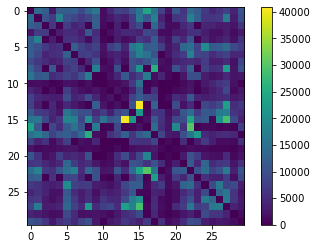

In [4]:
plt.figure()
plt.imshow(OD)
plt.colorbar()

## SLD

In [5]:
# metadata = pd.read_csv('./data/US-APT-Information.csv', index_col=0)
# metadata.head(2)

airport_df = pd.read_csv('./data/airport_core.csv')
airport_df = airport_df.sort_values(by='city')
airport_df.head(2)

,Airport,lat,lon,state,state_code,city
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston


In [6]:
sl_data = pd.read_csv('./data/Smart Location Data Export.csv')
sl_data['GEOID'] = sl_data['GEOID20'] // 10
sl_data['COUNTYID'] = sl_data['GEOID20'] // 1e7

In [7]:
sl_data.head(2)

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,VMT_tot_min,VMT_tot_max,VMT_tot_avg,GHG_per_worker,Annual_GHG,SLC_score,Shape_Length,Shape_Area,GEOID,COUNTYID
0,1,481130078254,481130078254,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,11.442995,82.636303,25.659327,24.499297,6369.817221,77.450956,3110.36082,297836.0831,48113007825,48113.0
1,2,481130078252,481130078252,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,11.442995,82.636303,25.659327,23.580987,6131.056669,78.898635,3519.46911,484945.1466,48113007825,48113.0


In [8]:
# may spend around 2 minutes
us_tract = gpd.GeoDataFrame(columns=['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON'])
for i in ['01','04','05','06','08','09',10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56]:
    try:
        tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_%i_tract.zip'%i)[['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON']]
    except:
        tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_%s_tract.zip'%i)[['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON']]
    us_tract = us_tract.append(tract)

us_tract.index = range(us_tract.shape[0])


In [9]:
def add_att(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'GEOID'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].sum()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].iloc[0]
    return df
    

In [34]:
att_lst = [
    'STATEFP', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p',\
    'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C', 'D4D', \
    'D5AR', 'D5AE', 'NatWalkInd', 'TotPop'
]

type_lst = [
    'same', 'same', 'same', 'same', 'same', 'sum', 'sum', 'sum',\
    'sum', 'sum', 'sum', 'sum', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',\
    'sum', 'sum', 'mean', 'sum'
]

assert(len(att_lst) == len(type_lst))

In [11]:
# may spend around 20~30 minutes
for i in range(len(att_lst)):
    us_tract = add_att(us_tract, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop


In [35]:
# may spend around 2 minutes
for i in us_tract.index:
    us_tract.loc[i, 'COUNTYID'] = us_tract.loc[i, 'GEOID'][:5]

att_lst.extend(['COUNTYID', 'GEOID', 'INTPTLAT', 'INTPTLON'])
type_lst.extend(['same', 'same', 'mean', 'mean'])


In [75]:
us_tract[['INTPTLAT', 'INTPTLON']] = us_tract[['INTPTLAT', 'INTPTLON']].astype(float)
us_tract.head(2)

,GEOID,geometry,INTPTLAT,INTPTLON,STATEFP,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,TotPop,COUNTYID
0,01055010700,"POLYGON ((-85.98699 34.04413, -85.98606 34.045...",34.072660,-85.899194,1,NaN,NaN,23460.0,"Gadsden, AL",69,...,3.610139,-99999.0,0.0,-99999.0,-99999.0,13684,13141,4.166667,3750,01055
1,01055001300,"POLYGON ((-86.00068 34.00537, -86.00023 34.006...",34.007878,-85.986595,1,NaN,NaN,23460.0,"Gadsden, AL",136,...,16.467295,-99999.0,0.0,-99999.0,-99999.0,54622,43352,8.666667,2807,01055


In [76]:
from shapely.ops import unary_union

def get_county_data():
    # 新建一个表格，找出各个county的数据（通过合并各个county的tract来实现）
    county_lst = us_tract['COUNTYID'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'COUNTYID', 'geometry']
    county_data = gpd.GeoDataFrame(columns=col_, index=range(len(county_lst)))
    
    for i in range(len(county_lst)):
        this_county_id = county_lst.iloc[i]
        this_county = us_tract[us_tract['COUNTYID']==this_county_id]
        polygons = this_county['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        county_data.loc[i, 'geometry'] = boundary.values
        county_data.loc[i, 'COUNTYID'] = this_county_id
        county_data.loc[i, 'TotPop'] = this_county['TotPop'].sum()
        
    return county_data

In [77]:
# may spend around 1.5 minutes
us_county = get_county_data()

In [78]:
us_county.head(2)

,TotPop,COUNTYID,geometry
0,102939,01055,"POLYGON ((-85.98820 33.87924, -85.99497 33.879..."
1,20298,01107,"POLYGON ((-88.33929 33.00300, -88.33845 33.010..."


In [79]:
def add_att_county(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'COUNTYID'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].sum()
        elif att == 'INTPTLAT' or att == 'INTPTLON':
            geoid_str = str(geoid)
            if len(geoid_str)!=5:
                geoid_str = '0' + geoid_str
            df.loc[i, att] = us_tract.loc[us_tract['COUNTYID']==geoid_str, att].mean()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].iloc[0]
    return df


In [80]:
for i in range(len(att_lst)):
    # except for COUNTYID and GEOID
    if att_lst[i]=='COUNTYID' or att_lst[i]=='GEOID':
        continue
    us_county = add_att_county(us_county, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop
Complete INTPTLAT
Complete INTPTLON


In [81]:
us_county.head(2)

,TotPop,COUNTYID,geometry,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
0,102939,01055,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN,NaN,23460.0,"Gadsden, AL",2441,12009,24327,...,10.617419,-99999.0,0.0,-99999.0,-99999.0,1028152,900253,6.238956,34.020991,-86.020571
1,20298,01107,"POLYGON ((-88.33929 33.00300, -88.33845 33.010...",NaN,NaN,46220.0,"Tuscaloosa, AL",731,2298,4501,...,1.801684,-99999.0,0.0,-99999.0,-99999.0,36617,40661,4.54386,33.339703,-88.079808


In [83]:
from shapely.ops import unary_union

def get_state_data():
    # 新建一个表格，找出各个state的数据（通过合并各个state的tract来实现）
    state_lst = us_tract['STATEFP'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'STATEFP', 'geometry']
    state_data = gpd.GeoDataFrame(columns=col_, index=range(len(state_lst)))
    
    for i in range(len(state_lst)):
        this_state_id = state_lst.iloc[i]
        this_state = us_tract[us_tract['STATEFP']==this_state_id]
        polygons = this_state['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        state_data.loc[i, 'geometry'] = boundary.values
        state_data.loc[i, 'STATEFP'] = this_state_id
        state_data.loc[i, 'TotPop'] = this_state['TotPop'].sum()
        
    return state_data

In [84]:
us_state = get_state_data()

In [87]:
def add_att_state(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    if att=='STATEFP':
        return df
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'STATEFP'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].sum()
        elif att == 'INTPTLAT' or att == 'INTPTLON':
            df.loc[i, att] = us_tract.loc[us_tract['STATEFP']==geoid, att].mean()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].iloc[0]
    return df
    

In [88]:
for i in range(len(att_lst)):
    # except for COUNTYID and GEOID
    if att_lst[i]=='COUNTYID' or att_lst[i]=='GEOID':
        continue
    us_state = add_att_state(us_state, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop
Complete INTPTLAT
Complete INTPTLON


In [89]:
us_state.head(2)

,TotPop,STATEFP,geometry,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
0,4864680,1,"POLYGON ((-88.06069 30.14442, -88.06919 30.146...",142.0,"Birmingham-Hoover-Talladega, AL",13820.0,"Birmingham-Hoover, AL",115360,602858,1142051,...,9.141649,-85691.056591,0.0,-85891.734212,-85890.980826,80015382,58768634,6.8312,32.937699,-86.770341
1,6946685,4,"POLYGON ((-112.62491 31.82102, -112.62548 31.8...",429.0,"Phoenix-Mesa, AZ",38060.0,"Phoenix-Mesa-Chandler, AZ",160011,912818,1451471,...,17.872108,-45943.701668,0.026742,-39583.881192,-39569.96112,285956773,225138695,10.104197,33.349931,-111.866664


In [90]:
from shapely.ops import unary_union

def get_CBSA_data():
    # 新建一个表格，找出各个 CBSA 的数据（通过合并各个 CBSA 来实现）
    CBSA_lst = us_tract['CBSA'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'CBSA', 'geometry']
    CBSA_data = gpd.GeoDataFrame(columns=col_, index=range(len(CBSA_lst)))
    
    for i in range(len(CBSA_lst)):
        this_CBSA_id = CBSA_lst.iloc[i]
        this_state = us_tract[us_tract['CBSA']==this_CBSA_id]
        polygons = this_state['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        CBSA_data.loc[i, 'geometry'] = boundary.values
        CBSA_data.loc[i, 'CBSA'] = this_CBSA_id
        CBSA_data.loc[i, 'TotPop'] = this_state['TotPop'].sum()
        
    return CBSA_data

In [91]:
us_CBSA = get_CBSA_data()

In [94]:
us_CBSA.head(2)

,TotPop,CBSA,geometry,CSA
0,102939,23460.0,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN
1,249824,46220.0,"POLYGON ((-87.52531 32.60098, -87.52531 32.600...",NaN


In [96]:
def add_att_CBSA(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    if att=='CBSA' or att=='CBSA_Name':
        return df
    df[att] = ''
    for i in df.index:
        try:
            geoid = int(df.loc[i, 'CBSA'])
        except:
            continue
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['CBSA']==geoid, att].sum()
        elif att == 'INTPTLAT' or att == 'INTPTLON':
            df.loc[i, att] = us_tract.loc[us_tract['CBSA']==geoid, att].mean()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['CBSA']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['CBSA']==geoid, att].iloc[0]
    return df
    

In [97]:
for i in range(len(att_lst)):
    # except for COUNTYID and GEOID
    if att_lst[i]=='COUNTYID' or att_lst[i]=='GEOID':
        continue
    us_CBSA = add_att_CBSA(us_CBSA, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop
Complete INTPTLAT
Complete INTPTLON


In [165]:
list(sl_data['CBSA_Name'].drop_duplicates())

['Dallas-Fort Worth-Arlington, TX',
 'Midland, TX',
 'Houston-The Woodlands-Sugar Land, TX',
 'Corpus Christi, TX',
 nan,
 'Lubbock, TX',
 'Beaumont-Port Arthur, TX',
 'Longview, TX',
 'Waco, TX',
 'Paris, TX',
 'Eagle Pass, TX',
 'Vernon, TX',
 'Abilene, TX',
 'Rio Grande City-Roma, TX',
 'Odessa, TX',
 'Austin-Round Rock-Georgetown, TX',
 'Amarillo, TX',
 'McAllen-Edinburg-Mission, TX',
 'Huntsville, TX',
 'San Antonio-New Braunfels, TX',
 'Granbury, TX',
 'Mount Pleasant, TX',
 'Killeen-Temple, TX',
 'Andrews, TX',
 'Brownsville-Harlingen, TX',
 'Laredo, TX',
 'San Angelo, TX',
 'Rockport, TX',
 'Sulphur Springs, TX',
 'El Paso, TX',
 'Sherman-Denison, TX',
 'Alice, TX',
 'Wichita Falls, TX',
 'College Station-Bryan, TX',
 'Borger, TX',
 'Tyler, TX',
 'El Campo, TX',
 'Victoria, TX',
 'Beeville, TX',
 'Kerrville, TX',
 'Kingsville, TX',
 'Corsicana, TX',
 'Plainview, TX',
 'Dumas, TX',
 'Bonham, TX',
 'Del Rio, TX',
 'Uvalde, TX',
 'Pecos, TX',
 'Levelland, TX',
 'Texarkana, TX-AR',

In [160]:
us_CBSA = us_CBSA.loc[us_CBSA['TotPop']!='']
us_CBSA.head(2)

,TotPop,CBSA,geometry,CSA,CSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageWk,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
0,102939,23460.0,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN,NaN,2441,12009,24327,37431,10413,...,10.617419,-99999.0,0.0,-99999.0,-99999.0,1028152,900253,6.238956,34.020991,-86.020571
1,249824,46220.0,"POLYGON ((-87.52531 32.60098, -87.52531 32.600...",NaN,NaN,6043,29777,52702,100155,25725,...,8.595404,-99999.0,0.0,-99999.0,-99999.0,2444455,1877340,6.16879,33.161686,-87.607731


In [140]:
from shapely.ops import unary_union

def get_CSA_data():
    # 新建一个表格，找出各个 CSA 的数据（通过合并各个 CSA 来实现）
    CSA_lst = us_tract['CSA'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'CSA', 'geometry']
    CSA_data = gpd.GeoDataFrame(columns=col_, index=range(len(CSA_lst)))
    
    for i in range(len(CSA_lst)):
        this_CSA_id = CSA_lst.iloc[i]
        this_state = us_tract[us_tract['CSA']==this_CSA_id]
        polygons = this_state['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        CSA_data.loc[i, 'geometry'] = boundary.values
        CSA_data.loc[i, 'CSA'] = this_CSA_id
        CSA_data.loc[i, 'TotPop'] = this_state['TotPop'].sum()
        
    return CSA_data

In [141]:
us_CSA = get_CSA_data()

In [142]:
us_CSA.head(2)

,TotPop,CSA,geometry
0,0,NaN,GEOMETRYCOLLECTION EMPTY
1,0,NaN,GEOMETRYCOLLECTION EMPTY


In [143]:
def add_att_CSA(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    if att=='CSA' or att=='CSA_Name':
        return df
    df[att] = ''
    for i in df.index:
        try:
            geoid = int(df.loc[i, 'CSA'])
        except:
            continue
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['CSA']==geoid, att].sum()
        elif att == 'INTPTLAT' or att == 'INTPTLON':
            df.loc[i, att] = us_tract.loc[us_tract['CSA']==geoid, att].mean()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['CSA']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['CSA']==geoid, att].iloc[0]
    return df
    

In [144]:
for i in range(len(att_lst)):
    # except for COUNTYID and GEOID
    if att_lst[i]=='COUNTYID' or att_lst[i]=='GEOID':
        continue
    us_CSA = add_att_CSA(us_CSA, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop
Complete INTPTLAT
Complete INTPTLON


In [147]:
us_CSA = us_CSA.loc[us_CSA['TotPop']!='']
us_CSA.head(2)

,TotPop,CSA,geometry,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageWk,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
17,479431,194.0,"POLYGON ((-85.05708 32.06306, -85.06051 32.063...",17980.0,"Columbus, GA-AL",14136,59520,104012,167966,45544,...,11.753172,-99999.0,0.0,-99999.0,-99999.0,4376655,3610037,6.603571,32.504683,-85.031173
22,1309932,142.0,"POLYGON ((-87.38763 33.00395, -87.38428 33.004...",13820.0,"Birmingham-Hoover, AL",30533,160222,312033,569465,125925,...,11.53353,-71466.884225,0.0,-65328.884063,-65326.752923,44392942,30146001,7.961177,33.518515,-86.760205


In [174]:
sl_data.loc[sl_data['CBSA_Name']=='Urban Honolulu, HI', 'CBSA']

78797    46520.0
78798    46520.0
78802    46520.0
78803    46520.0
78804    46520.0
          ...   
79622    46520.0
79623    46520.0
79624    46520.0
79625    46520.0
79626    46520.0
Name: CBSA, Length: 591, dtype: float64

In [184]:
us_CSA['CSA_Name'] = ''
for i in us_CSA.index:
    CSA = us_CSA.loc[i, 'CSA']
    us_CSA.loc[i, 'CSA_Name'] = sl_data.loc[sl_data['CSA']==CSA, 'CSA_Name'].drop_duplicates().values[0]

In [186]:
# 41740.0 represents 'San Diego-Chula Vista-Carlsbad, CA'
# 45300.0 represents 'Tampa-St. Petersburg-Clearwater, FL'
# 46520.0 represents 'Urban Honolulu, HI'

us_CSA = us_CSA.append(us_CBSA.loc[us_CBSA['CBSA']==41740.0])
us_CSA = us_CSA.append(us_CBSA.loc[us_CBSA['CBSA']==45300.0])
us_CSA = us_CSA.append(us_CBSA.loc[us_CBSA['CBSA']==46520.0])

In [188]:
us_CSA.index = range(us_CSA.shape[0])

In [192]:
us_CSA.loc[172, 'CSA_Name'] = 'San Diego-Chula Vista-Carlsbad, CA'
us_CSA.loc[173, 'CSA_Name'] = 'Tampa-St. Petersburg-Clearwater, FL'
us_CSA.loc[174, 'CSA_Name'] = 'Urban Honolulu, HI'
us_CSA

,TotPop,CSA,geometry,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageWk,...,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name
0,479431,194.0,"POLYGON ((-85.05708 32.06306, -85.06051 32.063...",17980.0,"Columbus, GA-AL",14136,59520,104012,167966,45544,...,-99999.0,0.0,-99999.0,-99999.0,4376655,3610037,6.603571,32.504683,-85.031173,"Columbus-Auburn-Opelika, GA-AL"
1,1309932,142.0,"POLYGON ((-87.38763 33.00395, -87.38428 33.004...",13820.0,"Birmingham-Hoover, AL",30533,160222,312033,569465,125925,...,-71466.884225,0.0,-65328.884063,-65326.752923,44392942,30146001,7.961177,33.518515,-86.760205,"Birmingham-Hoover-Talladega, AL"
2,465109,388.0,"POLYGON ((-86.39766 32.04395, -86.39714 32.043...",10760.0,"Alexander City, AL",14576,61471,105113,192893,46729,...,-58098.333573,0.0,-68798.605147,-68797.498709,8100556,6034957,8.642667,32.441734,-86.348443,"Montgomery-Selma-Alexander City, AL"
3,197222,222.0,"POLYGON ((-85.64746 30.99580, -85.64752 30.995...",20020.0,"Dothan, AL",4403,24997,45671,70662,17813,...,-99999.0,0.0,-99999.0,-99999.0,1369212,1135581,5.781046,31.283884,-85.487397,"Dothan-Ozark, AL"
4,639409,380.0,"POLYGON ((-88.04149 30.14561, -88.04610 30.144...",33660.0,"Mobile, AL",13317,82866,144277,251450,64804,...,-99999.0,0.0,-99999.0,-99999.0,8800828,7513325,6.809211,30.678931,-88.0674,"Mobile-Daphne-Fairhope, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,872646,357.0,"POLYGON ((-89.83766 42.62559, -89.83763 42.626...",27500.0,"Janesville-Beloit, WI",23408,118323,217198,490284,114648,...,-51586.152242,0.0,-47143.774644,-47073.152246,18838386,15949321,9.934757,43.012348,-89.386663,"Madison-Janesville-Beloit, WI"
171,306985,554.0,"POLYGON ((-89.72525 44.24773, -89.72559 44.247...",48140.0,"Wausau-Weston, WI",6723,37249,84554,155775,37053,...,-99999.0,0.0,-99999.0,-99999.0,2481684,2184955,6.734519,44.780545,-89.73656,"Wausau-Stevens Point-Wisconsin Rapids, WI"
172,3302833,NaN,"POLYGON ((-117.18915 32.52993, -117.20492 32.5...",41740.0,NaN,61486,341878,715616,1403191,283334,...,-24740.764089,0.101118,-75707.046067,-75697.271646,185201519,178384891,12.18663,32.868993,-117.110338,"San Diego-Chula Vista-Carlsbad, CA"
173,3030047,NaN,"POLYGON ((-82.82303 27.57055, -82.82367 27.575...",45300.0,NaN,82110,501444,613412,1307910,301944,...,-37825.352038,0.011225,-26223.297561,-26210.789328,135392614,107800161,11.017435,28.027517,-82.538297,"Tampa-St. Petersburg-Clearwater, FL"


In [139]:
# fig = plt.figure(figsize=[20,10])
# ax = fig.add_subplot(111)
# ax.set_xlim([-130, -110])
# ax.set_ylim([30, 45])
# us_state.plot(ax=ax, color='b', alpha=0.5)
# us_CBSA.plot(ax=ax, alpha=1, column='TotPop', cmap='RdPu')

In [193]:
# us_tract.fillna(0).to_file('./data/us_tract.shp', driver='ESRI Shapefile')
# us_county.fillna(0).to_file('./data/us_county.shp', driver='ESRI Shapefile')
# us_CBSA.fillna(0).to_file('./data/us_CBSA.shp', driver='ESRI Shapefile')
# us_CSA.fillna(0).to_file('./data/us_CSA.shp', driver='ESRI Shapefile')
# us_state.fillna(0).to_file('./data/us_state.shp', driver='ESRI Shapefile')

/var/folders/6v/_k68w5jd2fjdr7stnfl1_q_c0000gn/T/ipykernel_65020/460755578.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  us_CSA.fillna(0).to_file('./data/us_CSA.shp', driver='ESRI Shapefile')


# 找出各个机场的catchment area（county/city）

In [230]:
city_lst = list(sl_data['CSA_Name'].drop_duplicates().dropna().values)

In [231]:
airport_df['CSA_Name'] = ''

for i in airport_df.index:
    city = airport_df.loc[i, 'city'].split('/')[0]
#     print(city, 'is in the metropolis:')
    for j in range(len(city_lst)):
        metro_city_lst = city_lst[j].split(', ')[0].split('-')
        if city in metro_city_lst or city in metro_city_lst[0].split(' '):
            airport_df.loc[i, 'CSA_Name'] = city_lst[j]
#             print('\t', city_lst[j])
            break
        

In [238]:
airport_df.loc[airport_df['city']=='Honolulu', 'CSA_Name'] = 'Urban Honolulu, HI'
airport_df.loc[airport_df['city']=='San Diego', 'CSA_Name'] = 'San Diego-Chula Vista-Carlsbad, CA'
airport_df.loc[airport_df['city']=='Tampa', 'CSA_Name'] = 'Tampa-St. Petersburg-Clearwater, FL'
airport_df

,Airport,lat,lon,state,state_code,city,CSA_Name
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, ..."
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT"
3,CLT,35.219167,-80.935833,North Carolina,NC,Charlotte,"Charlotte-Concord, NC-SC"
22,ORD,41.978056,-87.906111,Illinois,IL,Chicago,"Chicago-Naperville, IL-IN-WI"
18,MDW,41.785000,-87.751944,Illinois,IL,Chicago,"Chicago-Naperville, IL-IN-WI"
6,DFW,32.894444,-97.029722,Texas,TX,Dallas/Fort Worth,"Dallas-Fort Worth, TX-OK"
5,DEN,39.774444,-104.879722,Colorado,CO,Denver,"Denver-Aurora, CO"
7,DTW,42.216667,-83.344444,Michigan,MI,Detroit,"Detroit-Warren-Ann Arbor, MI"
10,HNL,21.318611,-157.922500,Hawaii,HI,Honolulu,"Urban Honolulu, HI"
12,IAH,29.983333,-95.340000,Texas,TX,Houston,"Houston-The Woodlands, TX"


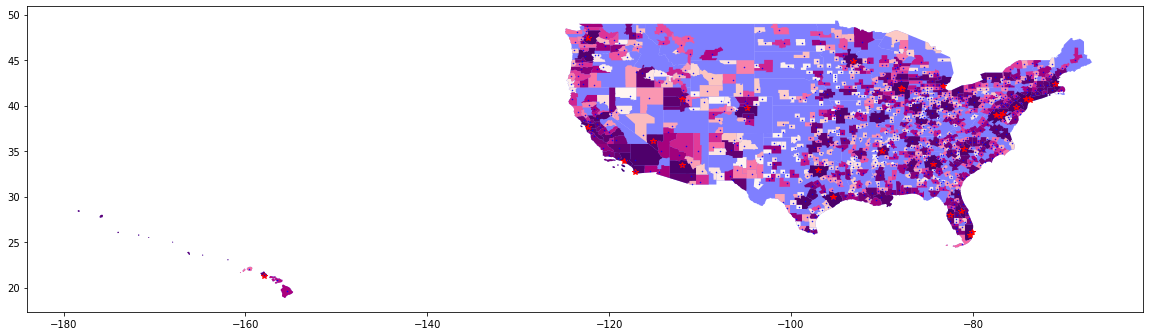

In [126]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_CBSA.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_CBSA.index:
    ax.plot(us_CBSA.loc[i, 'INTPTLON'], us_CBSA.loc[i, 'INTPTLAT'], 'b.', markersize=1)

# fig.savefig('./outputs/CBSA_with_airport.png', dpi=1000)

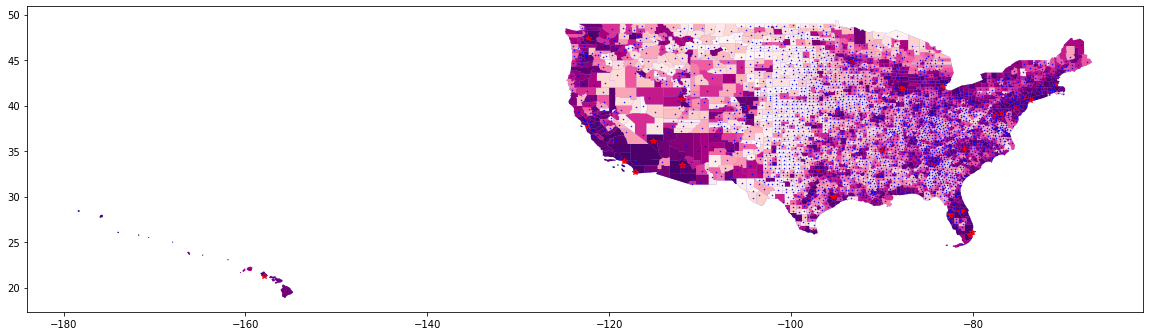

In [128]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_county.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_county.index:
    ax.plot(us_county.loc[i, 'INTPTLON'], us_county.loc[i, 'INTPTLAT'], 'b.', markersize=1)

# fig.savefig('./outputs/county_with_airport.png', dpi=1000)

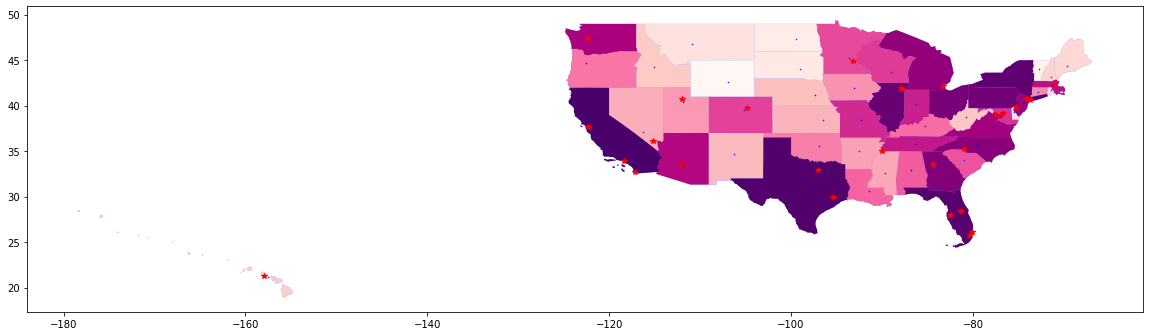

In [129]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_state.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_state.index:
    ax.plot(us_state.loc[i, 'INTPTLON'], us_state.loc[i, 'INTPTLAT'], 'b.', markersize=1)

# fig.savefig('./outputs/state_with_airport.png', dpi=1000)

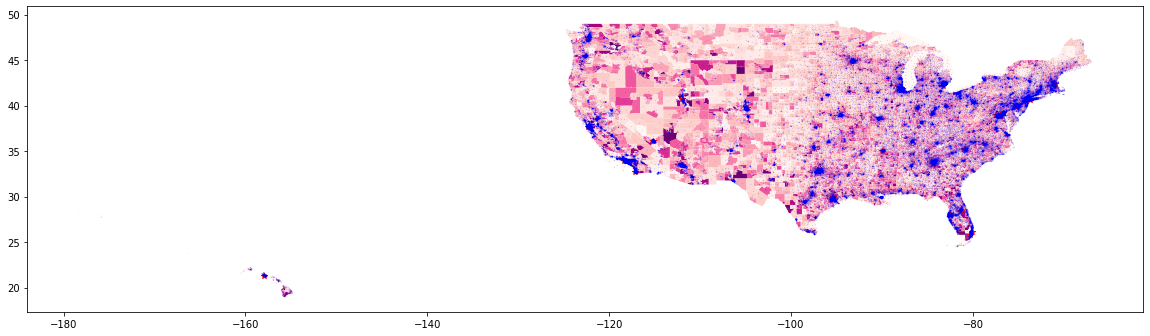

In [153]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_tract.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_tract.index:
    ax.plot(us_tract.loc[i, 'INTPTLON'], us_tract.loc[i, 'INTPTLAT'], 'b.', markersize=.1)

fig.savefig('./outputs/tract_with_airport.png', dpi=1000)

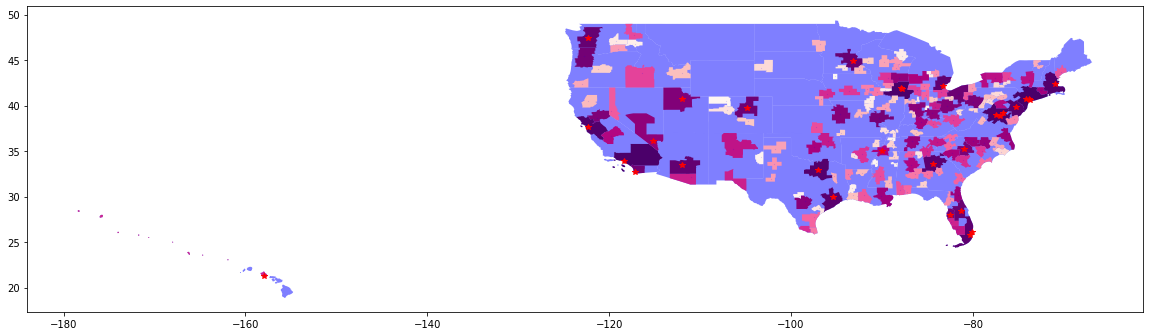

In [239]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_CSA.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_CSA.index:
    ax.plot(us_CSA.loc[i, 'INTPTLON'], us_CSA.loc[i, 'INTPTLAT'], 'b.', markersize=.1)

# fig.savefig('./outputs/CSA_with_airport.png', dpi=1000)

# Merge Airport

In [240]:
airport_df.sort_values(by='city')

,Airport,lat,lon,state,state_code,city,CSA_Name
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, ..."
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT"
3,CLT,35.219167,-80.935833,North Carolina,NC,Charlotte,"Charlotte-Concord, NC-SC"
22,ORD,41.978056,-87.906111,Illinois,IL,Chicago,"Chicago-Naperville, IL-IN-WI"
18,MDW,41.785000,-87.751944,Illinois,IL,Chicago,"Chicago-Naperville, IL-IN-WI"
6,DFW,32.894444,-97.029722,Texas,TX,Dallas/Fort Worth,"Dallas-Fort Worth, TX-OK"
5,DEN,39.774444,-104.879722,Colorado,CO,Denver,"Denver-Aurora, CO"
7,DTW,42.216667,-83.344444,Michigan,MI,Detroit,"Detroit-Warren-Ann Arbor, MI"
10,HNL,21.318611,-157.922500,Hawaii,HI,Honolulu,"Urban Honolulu, HI"
12,IAH,29.983333,-95.340000,Texas,TX,Houston,"Houston-The Woodlands, TX"


In [241]:
merged_airport_dict = {
    'ORD' : 'CHI',
    'MDW' : 'CHI',
    'FLL' : 'MIA',
    'MIA' : 'MIA',
    'EWR' : 'NYC',
    'JFK' : 'NYC',
    'LGA' : 'NYC',
    'BWI' : 'WAS',
    'DCA' : 'WAS',
    'IAD' : 'WAS'
}
merged_airport_lst = ['ORD', 'MDW', 'FLL', 'MIA', 'EWR', 'JFK', 'LGA', 'BWI', 'DCA', 'IAD']

In [242]:
CSA_df = pd.DataFrame(columns=airport_df.columns)

In [266]:
for i in airport_df.index:
    airport = airport_df.loc[i, 'Airport']
    if airport not in merged_airport_lst:
        CSA_df.loc[i, :] = airport_df.loc[i, :]
    else:
        city = airport_df.loc[i, 'city']
        CSA_df.loc[i, 'Airport'] = merged_airport_dict[airport]
        CSA_df.loc[i, 'lat'] = airport_df.loc[airport_df['city']==city, 'lat'].mean()
        CSA_df.loc[i, 'lon'] = airport_df.loc[airport_df['city']==city, 'lon'].mean()
        CSA_df.loc[i, 'state'] = airport_df.loc[i, 'state']
        CSA_df.loc[i, 'state_code'] = airport_df.loc[i, 'state_code']
        CSA_df.loc[i, 'city'] = airport_df.loc[i, 'city']
        CSA_df.loc[i, 'CSA_Name'] = airport_df.loc[i, 'CSA_Name']
        
CSA_df = CSA_df.drop_duplicates(['Airport'])
CSA_df.index = range(CSA_df.shape[0])

In [269]:
CSA_df

,Airport,lat,lon,state,state_code,city,CSA_Name
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, ..."
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT"
2,WAS,38.989444,-77.054815,Maryland,MD,Washington,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA"
3,CLT,35.219167,-80.935833,North Carolina,NC,Charlotte,"Charlotte-Concord, NC-SC"
4,DEN,39.774444,-104.879722,Colorado,CO,Denver,"Denver-Aurora, CO"
5,DFW,32.894444,-97.029722,Texas,TX,Dallas/Fort Worth,"Dallas-Fort Worth, TX-OK"
6,DTW,42.216667,-83.344444,Michigan,MI,Detroit,"Detroit-Warren-Ann Arbor, MI"
7,NYC,40.70463,-73.941481,New Jersey,NJ,New York,"New York-Newark, NY-NJ-CT-PA"
8,MIA,25.933333,-80.218889,Florida,FL,Miami,"Miami-Port St. Lucie-Fort Lauderdale, FL"
9,HNL,21.318611,-157.9225,Hawaii,HI,Honolulu,"Urban Honolulu, HI"


In [259]:
us_CSA['if_plot'] = 0
for i in us_CSA.index:
    if us_CSA.loc[i, 'CSA_Name'] in CSA_df['CSA_Name'].values:
        us_CSA.loc[i, 'if_plot'] = 1

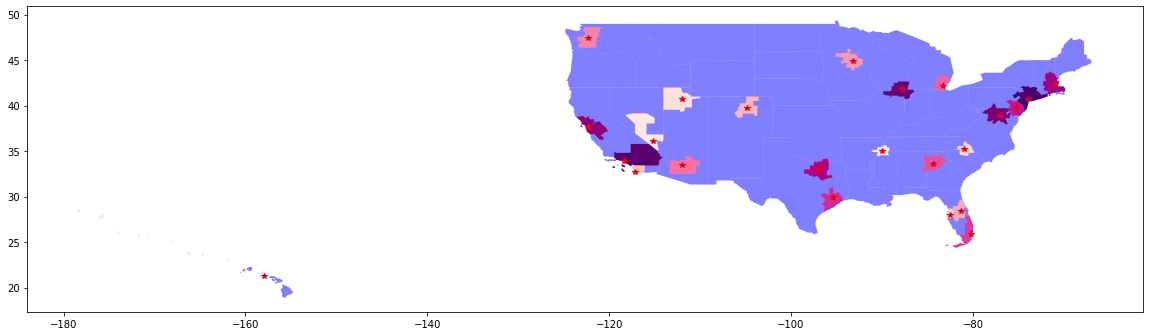

In [263]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_CSA.loc[us_CSA['if_plot']==1].plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in CSA_df.index:
    lon = CSA_df.loc[i, 'lon']
    lat = CSA_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_CSA.index:
    if us_CSA.loc[i, 'CSA_Name'] in CSA_df['CSA_Name'].values:
        ax.plot(us_CSA.loc[i, 'INTPTLON'], us_CSA.loc[i, 'INTPTLAT'], 'b.', markersize=1)

# fig.savefig('./outputs/CSA_with_airport_merged.png', dpi=1000)

In [309]:
def get_OD_CSA(year, quarter):
    OD_CSA = pd.read_csv('./outputs/%i0%i_OD.csv'%(year, quarter), index_col=0)

    OD_CSA['CHI'] = ''
    OD_CSA.loc['CHI'] = ''
    OD_CSA['CHI'] = OD_CSA['ORD'] + OD_CSA['MDW']
    OD_CSA.loc['CHI'] = OD_CSA.loc['ORD'] + OD_CSA.loc['MDW']

    OD_CSA['MIA'] = OD_CSA['MIA'] + OD_CSA['FLL']
    OD_CSA.loc['MIA'] = OD_CSA.loc['MIA'] + OD_CSA.loc['FLL']

    OD_CSA['NYC'] = ''
    OD_CSA.loc['NYC'] = ''
    OD_CSA['NYC'] = OD_CSA['EWR'] + OD_CSA['JFK'] + OD_CSA['LGA']
    OD_CSA.loc['NYC'] = OD_CSA.loc['EWR'] + OD_CSA.loc['JFK'] + OD_CSA.loc['LGA']

    OD_CSA['WAS'] = ''
    OD_CSA.loc['WAS'] = ''
    OD_CSA['WAS'] = OD_CSA['BWI'] + OD_CSA['DCA'] + OD_CSA['IAD']
    OD_CSA.loc['WAS'] = OD_CSA.loc['BWI'] + OD_CSA.loc['DCA'] + OD_CSA.loc['IAD']

    OD_CSA = OD_CSA.drop(['ORD', 'MDW', 'FLL', 'EWR', 'JFK', 'LGA', 'BWI', 'DCA', 'IAD'], axis=0)
    OD_CSA = OD_CSA.drop(['ORD', 'MDW', 'FLL', 'EWR', 'JFK', 'LGA', 'BWI', 'DCA', 'IAD'], axis=1)

    return OD_CSA


In [311]:
for year in [2018, 2019, 2020, 2021]:
    for quarter in [1, 2, 3, 4]:
        OD_CSA = get_OD_CSA(year, quarter)
        OD_CSA.to_csv('./outputs/%i0%i_OD_CSA.csv'%(year, quarter))

In [315]:
OD_CSA.shape

(24, 24)

In [323]:
# us_CSA.loc[us_CSA['if_plot']==1].fillna(0).to_file('./data/us_CSA_final.shp', driver='ESRI Shapefile')

/var/folders/6v/_k68w5jd2fjdr7stnfl1_q_c0000gn/T/ipykernel_65020/3692187450.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  us_CSA.loc[us_CSA['if_plot']==1].fillna(0).to_file('./data/us_CSA_final.shp', driver='ESRI Shapefile')
